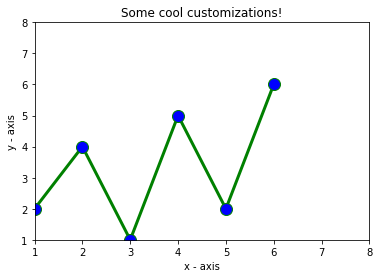

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# x axis values
x = [1,2,3,4,5,6]
# corresponding y axis values
y = [2,4,1,5,2,6]
  
# plotting the points 
plt.plot(x, y, color='green', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=12)
  
# setting x and y axis range
plt.ylim(1,8)
plt.xlim(1,8)
  
# naming the x axis
plt.xlabel('x - axis')
# naming the y axis
plt.ylabel('y - axis')
  
# giving a title to my graph
plt.title('Some cool customizations!')
  
# function to show the plot
plt.show()

In [ ]:
def drawPlot(G,R,W):
    for v in G:
        x = [v[0]]
        y = [v[1]]
        plt.plot(x, y, color='green', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=12)
  
        # setting x and y axis range
        plt.ylim(1,8)
        plt.xlim(1,8)